In [3]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
from transformers import DeiTFeatureExtractor, DeiTForImageClassification

In [4]:
dataset = load_dataset("e1010101/tongue-images")

In [5]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

In [7]:
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

In [9]:
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)

In [10]:
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

In [13]:
# Fine-tune of deit-small-patch-224
model = DeiTForImageClassification.from_pretrained('checkpoints/checkpoint-700')

In [25]:
# model.config.id2label

In [82]:
image = dataset["test"]["image"][70]
image_tensor = transforms.ToTensor()(image)

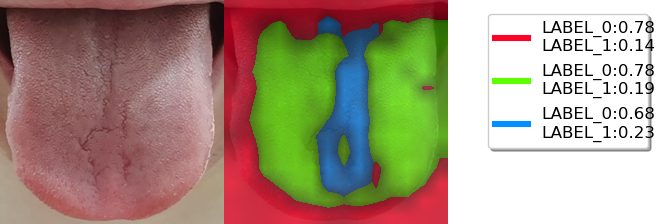

In [83]:
import math
def reshape_transform_deit_huggingface(x):
    # Remove the class token
    activations = x[:, 1:, :]
    
    # Calculate the number of patches
    # For a 224x224 image with 16x16 patches, it's 14x14
    activations = x[:, 1:-1, :]  # Remove first and last tokens

    num_patches = activations.shape[1]
    grid_size = int(math.sqrt(num_patches))
    
    # Calculate the grid size (assuming square grid)
    grid_size = int(num_patches ** 0.5)
    assert grid_size * grid_size == num_patches, "Number of patches is not a perfect square."
    
    # Reshape to [batch_size, grid_size, grid_size, hidden_dim]
    activations = activations.view(activations.shape[0],
                                   grid_size, grid_size, activations.shape[2])
    
    # Rearrange dimensions to [batch_size, hidden_dim, grid_size, grid_size]
    activations = activations.permute(0, 3, 1, 2)
    return activations

targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "LABEL_0")),
                       ClassifierOutputTarget(category_name_to_index(model, "LABEL_1")),
                       ClassifierOutputTarget(category_name_to_index(model, "LABEL_2"))]
target_layer_dff = model.deit.layernorm
target_layer_gradcam = model.deit.encoder.layer[-2].output
image_resized = image.resize((224, 224))
tensor_resized = transforms.ToTensor()(image_resized)


display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image_resized,
                          img_tensor=tensor_resized,
                          reshape_transform=reshape_transform_deit_huggingface,
                          n_components=3,
                          top_k=2)))

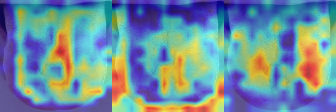

In [84]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=tensor_resized,
                      input_image=image_resized,
                      reshape_transform=reshape_transform_deit_huggingface)))

In [70]:
pred = model(tensor_resized.unsqueeze(0))

In [71]:
pred = torch.nn.functional.softmax(pred.logits, dim=1)
pred

tensor([[0.9663, 0.0015, 0.0321]], grad_fn=<SoftmaxBackward0>)

In [35]:
print_top_categories(model, tensor_resized)

Predicted class 1: LABEL_1
Predicted class 2: LABEL_2
Predicted class 0: LABEL_0
